# Image classification

## Setup

Import TensorFlow and other necessary libraries:

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

## Load and explore the dataset

In [13]:
import pathlib
data_dir = pathlib.Path('/home/jaikhurana/Developer/Cheese-Lock/Cheese-Lock/Data')

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

15186


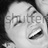

In [15]:
smile = list(data_dir.glob('smile/*'))
PIL.Image.open(str(smile[10]))

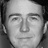

In [16]:
PIL.Image.open(str(smile[11]))

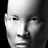

In [17]:
nosmile = list(data_dir.glob('no-smile/*'))
PIL.Image.open(str(nosmile[3]))

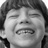

In [18]:
PIL.Image.open(str(smile[5]))

## Load data using a Keras utility

Next, load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory` utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [Load and preprocess images](../load_data/images.ipynb) tutorial.

### Create a dataset

Define some parameters for the loader:

In [19]:
batch_size = 64
img_height = 140
img_width = 140

It's good practice to use a validation split when developing your model. Use 80% of the images for training and 20% for validation.

In [20]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)


Found 15186 files belonging to 2 classes.
Using 12149 files for training.


2023-03-04 21:35:47.526337: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-03-04 21:35:47.526796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-04 21:35:47.526902: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-03-04 21:35:47.526996: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-03-04 21:35:47.527248: W tensorflow/c

In [21]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 15186 files belonging to 2 classes.
Using 3037 files for validation.


You can find the class names in the `class_names` attribute on these datasets. These correspond to the directory names in alphabetical order.

In [22]:
class_names = train_ds.class_names
print(class_names)

['no-smile', 'smile']


## Visualize the data

Here are the first nine images from the training dataset:

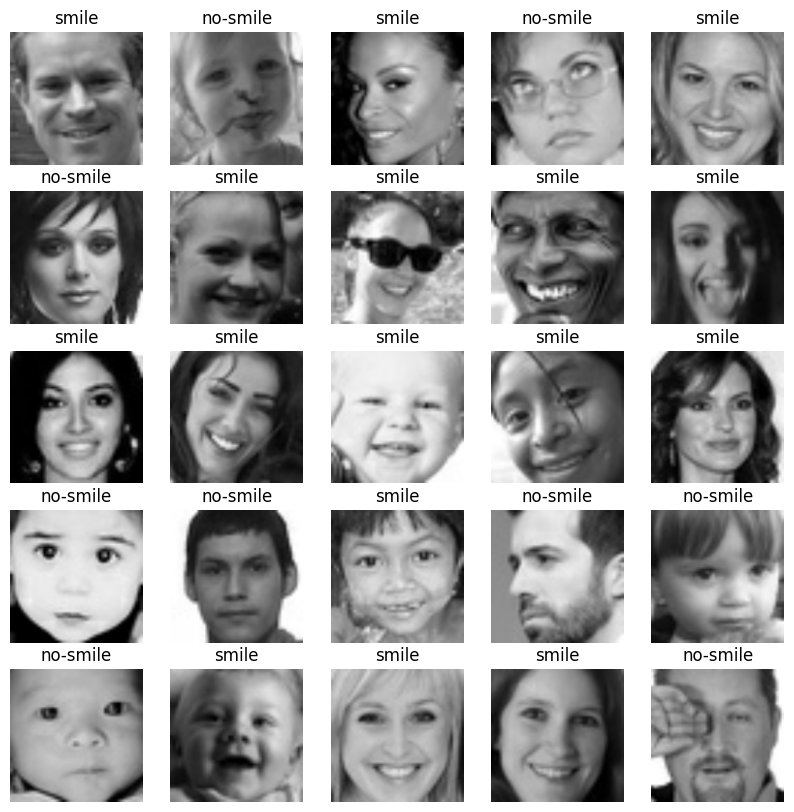

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

You will pass these datasets to the Keras `Model.fit` method for training later in this tutorial. If you like, you can also manually iterate over the dataset and retrieve batches of images:

In [24]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(64, 140, 140, 3)
(64,)


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

You can call `.numpy()` on the `image_batch` and `labels_batch` tensors to convert them to a `numpy.ndarray`.


## Configure the dataset for performance

Make sure to use buffered prefetching, so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

- `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
- `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](../../guide/data_performance.ipynb) guide.

In [25]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Standardize the data

The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [26]:
normalization_layer = layers.Rescaling(1./255)

There are two ways to use this layer. You can apply it to the dataset by calling `Dataset.map`:

In [27]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
0.29677883 1.0


Or, you can include the layer inside your model definition, which can simplify deployment. Use the second approach here.

Note: You previously resized images using the `image_size` argument of `tf.keras.utils.image_dataset_from_directory`. If you want to include the resizing logic in your model as well, you can use the `tf.keras.layers.Resizing` layer.

## A basic Keras model

### Create the model

The Keras [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned for high accuracy; the goal of this tutorial is to show a standard approach.

In [28]:
num_classes_classes = len(class_names)

In [29]:
num_classes = len(class_names)

model = Sequential([
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, (3,3), padding='same', activation='relu'),
  layers.Conv2D(32, (3,3), padding='same', activation='relu'),
  layers.Conv2D(64, (3,3), padding='same', activation='relu'),
  layers.Dropout(0.25),
  layers.Dense(64, activation='relu'),
  layers.Flatten(),
  layers.Dense(256, activation='relu'),
  layers.BatchNormalization(),
  layers.Dense(512, activation='relu'),
  layers.BatchNormalization(),
  
  layers.Dense(7, activation='softmax'),

  layers.Flatten(),
  layers.Dense(num_classes)
])


2023-03-04 21:36:02.424278: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1284505600 exceeds 10% of free system memory.
2023-03-04 21:36:06.760826: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1284505600 exceeds 10% of free system memory.
2023-03-04 21:36:09.472660: W tensorflow/tsl/framework/cpu_allocator_impl.cc:82] Allocation of 1284505600 exceeds 10% of free system memory.


In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_1 (Rescaling)     (None, 140, 140, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 140, 140, 16)      448       
                                                                 
 conv2d_1 (Conv2D)           (None, 140, 140, 32)      4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 140, 140, 64)      18496     
                                                                 
 dropout (Dropout)           (None, 140, 140, 64)      0         
                                                                 
 dense (Dense)               (None, 140, 140, 64)      4160      
                                                                 
 flatten (Flatten)           (None, 1254400)           0

### Compile the model

For this tutorial, choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [31]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Train the model

Train the model for 10 epochs with the Keras `Model.fit` method:

In [1]:
epochs = 5
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

NameError: name 'model' is not defined

## Visualize training results

Create plots of the loss and accuracy on the training and validation sets:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

The plots show that training accuracy and validation accuracy are off by large margins, and the model has achieved only around 60% accuracy on the validation set.

The following tutorial sections show how to inspect what went wrong and try to increase the overall performance of the model.

## Overfitting

In the plots above, the training accuracy is increasing linearly over time, whereas validation accuracy stalls around 60% in the training process. Also, the difference in accuracy between training and validation accuracy is noticeable—a sign of [overfitting](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit).

When there are a small number of training examples, the model sometimes learns from noises or unwanted details from training examples—to an extent that it negatively impacts the performance of the model on new examples. This phenomenon is known as overfitting. It means that the model will have a difficult time generalizing on a new dataset.

There are multiple ways to fight overfitting in the training process. In this tutorial, you'll use *data augmentation* and add *dropout* to your model.

## Data augmentation

Overfitting generally occurs when there are a small number of training examples. [Data augmentation](./data_augmentation.ipynb) takes the approach of generating additional training data from your existing examples by augmenting them using random transformations that yield believable-looking images. This helps expose the model to more aspects of the data and generalize better.

You will implement data augmentation using the following Keras preprocessing layers: `tf.keras.layers.RandomFlip`, `tf.keras.layers.RandomRotation`, and `tf.keras.layers.RandomZoom`. These can be included inside your model like other layers, and run on the GPU.

In [ ]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

Visualize a few augmented examples by applying data augmentation to the same image several times:

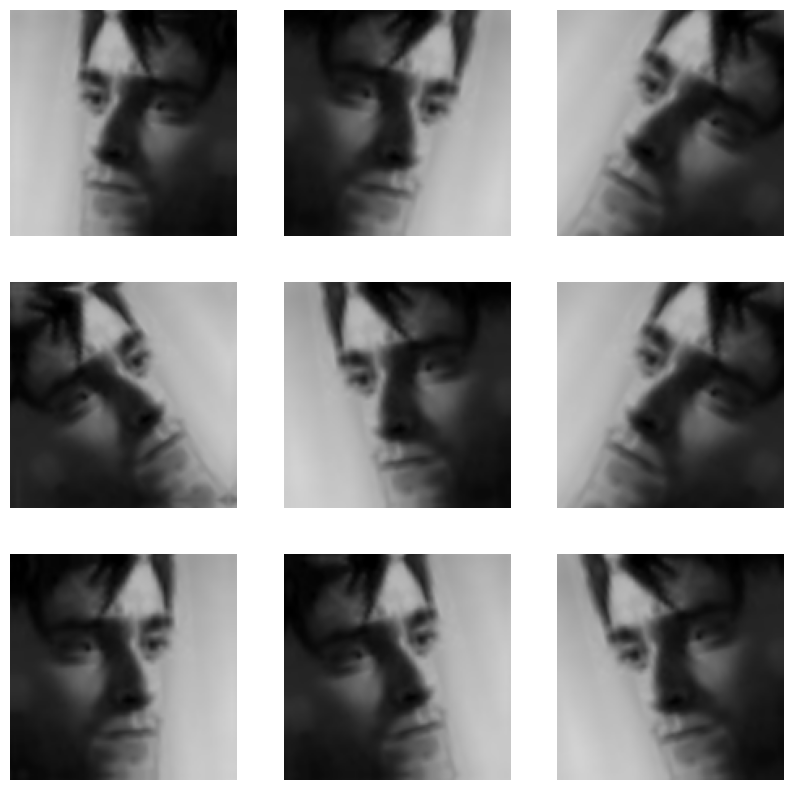

In [ ]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")
    

You will add data augmentation to your model before training in the next step.

## Dropout

Another technique to reduce overfitting is to introduce [dropout](https://developers.google.com/machine-learning/glossary#dropout_regularization){:.external} regularization to the network.

When you apply dropout to a layer, it randomly drops out (by setting the activation to zero) a number of output units from the layer during the training process. Dropout takes a fractional number as its input value, in the form such as 0.1, 0.2, 0.4, etc. This means dropping out 10%, 20% or 40% of the output units randomly from the applied layer.

Create a new neural network with `tf.keras.layers.Dropout` before training it using the augmented images:

In [ ]:
model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes, name="outputs")
])

## Compile and train the model

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 140, 140, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 140, 140, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 140, 140, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 70, 70, 16)       0         
 )                                                               
                                                                 
 conv2d_4 (Conv2D)           (None, 70, 70, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 35, 35, 32)       0         
 2D)                                                  

In [ ]:
epochs = 100
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/100
190/190 [==============================] - 64s 324ms/step - loss: 0.6557 - accuracy: 0.6103 - val_loss: 0.5836 - val_accuracy: 0.7056
Epoch 2/100
190/190 [==============================] - 56s 295ms/step - loss: 0.5890 - accuracy: 0.6942 - val_loss: 0.5319 - val_accuracy: 0.7468
Epoch 3/100
190/190 [==============================] - 57s 298ms/step - loss: 0.5604 - accuracy: 0.7229 - val_loss: 0.5232 - val_accuracy: 0.7596
Epoch 4/100
190/190 [==============================] - 57s 299ms/step - loss: 0.5362 - accuracy: 0.7308 - val_loss: 0.4813 - val_accuracy: 0.7685
Epoch 5/100
190/190 [==============================] - 56s 296ms/step - loss: 0.5122 - accuracy: 0.7412 - val_loss: 0.4689 - val_accuracy: 0.7731
Epoch 6/100
190/190 [==============================] - 57s 299ms/step - loss: 0.4919 - accuracy: 0.7525 - val_loss: 0.4433 - val_accuracy: 0.7870
Epoch 7/100
190/190 [==============================] - 57s 299ms/step - loss: 0.4694 - accuracy: 0.7713 - val_loss: 0.4199 -

190/190 [==============================] - 57s 299ms/step - loss: 0.2412 - accuracy: 0.8961 - val_loss: 0.3415 - val_accuracy: 0.8650
Epoch 41/100
190/190 [==============================] - 56s 297ms/step - loss: 0.2371 - accuracy: 0.9004 - val_loss: 0.3385 - val_accuracy: 0.8676
Epoch 42/100
190/190 [==============================] - 56s 297ms/step - loss: 0.2281 - accuracy: 0.9053 - val_loss: 0.3359 - val_accuracy: 0.8617
Epoch 43/100
190/190 [==============================] - 57s 298ms/step - loss: 0.2329 - accuracy: 0.9047 - val_loss: 0.3501 - val_accuracy: 0.8607
Epoch 44/100
190/190 [==============================] - 56s 297ms/step - loss: 0.2326 - accuracy: 0.9052 - val_loss: 0.3532 - val_accuracy: 0.8597
Epoch 45/100
190/190 [==============================] - 57s 299ms/step - loss: 0.2289 - accuracy: 0.9062 - val_loss: 0.3472 - val_accuracy: 0.8617
Epoch 46/100
190/190 [==============================] - 56s 297ms/step - loss: 0.2261 - accuracy: 0.9087 - val_loss: 0.3398 - val_a

Epoch 96/100
190/190 [==============================] - 56s 297ms/step - loss: 0.1336 - accuracy: 0.9475 - val_loss: 0.4224 - val_accuracy: 0.8584
Epoch 97/100
190/190 [==============================] - 57s 302ms/step - loss: 0.1327 - accuracy: 0.9497 - val_loss: 0.4353 - val_accuracy: 0.8650
Epoch 98/100
190/190 [==============================] - 57s 299ms/step - loss: 0.1270 - accuracy: 0.9490 - val_loss: 0.4310 - val_accuracy: 0.8683
Epoch 99/100
190/190 [==============================] - 56s 296ms/step - loss: 0.1374 - accuracy: 0.9465 - val_loss: 0.4339 - val_accuracy: 0.8666
Epoch 100/100
190/190 [==============================] - 56s 297ms/step - loss: 0.1364 - accuracy: 0.9495 - val_loss: 0.4254 - val_accuracy: 0.8683


## Visualize training results

After applying data augmentation and `tf.keras.layers.Dropout`, there is less overfitting than before, and training and validation accuracy are closer aligned:

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## Predict on new data

Use your model to classify an image that wasn't included in the training or validation sets.

Note: Data augmentation and dropout layers are inactive at inference time.

## Saving the Model.h5

In [ ]:
model.save("model.h5")

## Use TensorFlow Lite

TensorFlow Lite is a set of tools that enables on-device machine learning by helping developers run their models on mobile, embedded, and edge devices.

### Convert the Keras Sequential model to a TensorFlow Lite model

To use the trained model with on-device applications, first [convert it](https://www.tensorflow.org/lite/models/convert) to a smaller and more efficient model format called a [TensorFlow Lite](https://www.tensorflow.org/lite/) model.

In this example, take the trained Keras Sequential model and use `tf.lite.TFLiteConverter.from_keras_model` to generate a [TensorFlow Lite](https://www.tensorflow.org/lite/) model:

In [ ]:
# Convert the model.
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp3lcsp56y/assets


INFO:tensorflow:Assets written to: /tmp/tmp3lcsp56y/assets
2023-02-10 16:54:47.689444: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2023-02-10 16:54:47.689695: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2023-02-10 16:54:47.704918: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp3lcsp56y
2023-02-10 16:54:47.728044: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2023-02-10 16:54:47.728097: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp3lcsp56y
2023-02-10 16:54:47.789535: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:357] MLIR V1 optimization pass is not enabled
2023-02-10 16:54:47.803093: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2023-02-10 16:54:47.998474: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

The TensorFlow Lite model you saved in the previous step can contain several function signatures. The Keras model converter API uses the default signature automatically. Learn more about [TensorFlow Lite signatures](https://www.tensorflow.org/lite/guide/signatures).

### Run the TensorFlow Lite model

You can access the TensorFlow Lite saved model signatures in Python via the `tf.lite.Interpreter` class.

Load the model with the `Interpreter`:

In [ ]:
TF_MODEL_FILE_PATH = 'model.tflite' # The default path to the saved TensorFlow Lite model

interpreter = tf.lite.Interpreter(model_path=TF_MODEL_FILE_PATH)

Print the signatures from the converted model to obtain the names of the inputs (and outputs):


In [ ]:
interpreter.get_signature_list()

{'serving_default': {'inputs': ['sequential_1_input'], 'outputs': ['outputs']}}

In this example, you have one default signature called `serving_default`. In addition, the name of the `'inputs'` is `'sequential_1_input'`, while the `'outputs'` are called `'outputs'`. You can look up these first and last Keras layer names when running `Model.summary`, as demonstrated earlier in this tutorial.

Now you can test the loaded TensorFlow Model by performing inference on a sample image with `tf.lite.Interpreter.get_signature_runner` by passing the signature name as follows:

In [ ]:
classify_lite = interpreter.get_signature_runner('serving_default')
classify_lite

Similar to what you did earlier in the tutorial, you can use the TensorFlow Lite model to classify images that weren't included in the training or validation sets.

You have already tensorized that image and saved it as `img_array`. Now, pass it to the first argument (the name of the `'inputs'`) of the loaded TensorFlow Lite model (`predictions_lite`), compute softmax activations, and then print the prediction for the class with the highest computed probability.

In [ ]:
predictions_lite = classify_lite(sequential_1_input=img_array)['outputs']
score_lite = tf.nn.softmax(predictions_lite)

NameError: name 'img_array' is not defined

In [ ]:
print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score_lite)], 100 * np.max(score_lite))
)

The prediction generated by the lite model should be almost identical to the predictions generated by the original model:

In [ ]:
print(np.max(np.abs(predictions - predictions_lite)))